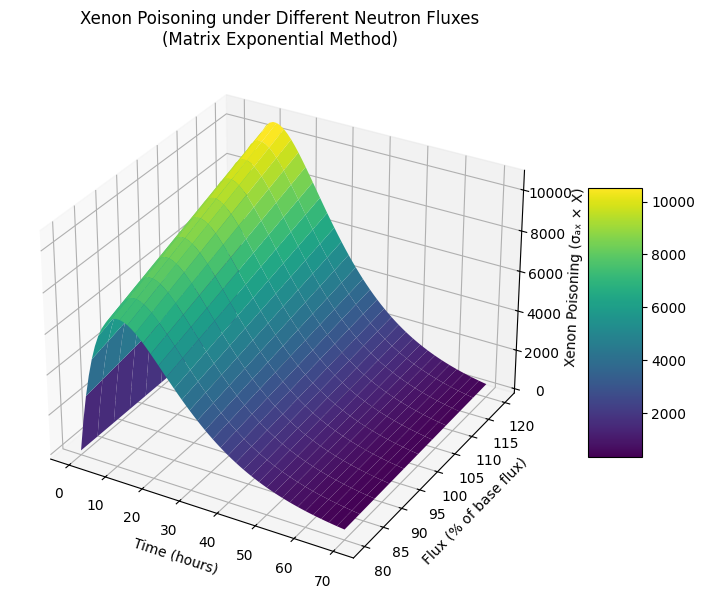

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# ---------------------------
# Fixed Nuclear Constants
# ---------------------------
lamI = 2.874e-5       # Decay constant for I-135 (1/s)
lamX = 2.027e-5       # Decay constant for Xe-135 (1/s)
Y_I  = 0.061          # Fission yield for I-135
Y_X  = 0.003          # Fission yield for Xe-135
sigma_aX = 2.75e-18   # Microscopic absorption cross-section of Xe-135 (cm^2)

# Base reactor parameters
phi_base = 4.42e20    # Base neutron flux (n/cm^2/s) at 100% power
Sig_f = 0.008         # Macroscopic fission cross-section (1/cm)

# ---------------------------
# Equilibrium Calculation Function
# ---------------------------
def equilibrium_I_X(phi, Sig_f, Y_I, Y_X, lamI, lamX, sigma_aX):
    """
    Computes the equilibrium concentrations before shutdown.
    At equilibrium:
       I0 = (Y_I * Sig_f * phi) / lamI
       X0 = (Y_X * Sig_f * phi + lamI * I0) / (lamX + sigma_aX * phi)
    """
    I0 = (Y_I * Sig_f * phi) / lamI
    X0 = (Y_X * Sig_f * phi + lamI * I0) / (lamX + sigma_aX * phi)
    return I0, X0

# ---------------------------
# Matrix Exponential Poisoning Simulation
# ---------------------------
def simulate_poisoning_expm(phi, t):
    """
    Computes the xenon poisoning at time t (in seconds) using the matrix exponential method.
    For the shutdown ODE system:
       dI/dt = -lamI * I
       dX/dt = lamI * I - lamX * X
    which in matrix form is:
       d/dt [I; X] = A [I; X]    with    A = [[ -lamI,  0 ],
                                                 [  lamI, -lamX]]
    Returns:
       Poisoning = sigma_aX * X(t)
    """
    I0, X0 = equilibrium_I_X(phi, Sig_f, Y_I, Y_X, lamI, lamX, sigma_aX)
    A = np.array([[-lamI, 0],
                  [ lamI, -lamX]])
    # Compute state at time t: [I(t); X(t)] = expm(A*t) * [I0; X0]
    state = expm(A * t) @ np.array([I0, X0])
    X_val = state[1]
    poisoning = sigma_aX * X_val
    return poisoning

# ---------------------------
# Create 3D Grid for Plotting
# ---------------------------
# Time range: from 0 to 70 hours, in 1-hour steps.
t_hours = np.linspace(0, 70, 71)
t_seconds = t_hours * 3600.0  # convert hours to seconds

# Flux range: from 80% to 120% of the base flux, in 4% increments.
flux_percentages = np.arange(80, 121, 4)  # in percent
# We'll use flux percentage on the y-axis for clarity.
# Compute absolute flux values:
flux_levels = flux_percentages / 100.0 * phi_base

# Create an empty grid for poisoning: rows for flux, columns for time.
poisoning_grid = np.zeros((len(flux_levels), len(t_seconds)))

# Fill the grid: for each flux level and each time point, compute poisoning.
for i, phi in enumerate(flux_levels):
    for j, t in enumerate(t_seconds):
        poisoning_grid[i, j] = simulate_poisoning_expm(phi, t)

# ---------------------------
# Create 3D Surface Plot
# ---------------------------
# Create meshgrids for time (X-axis) and flux percentage (Y-axis)
T, F = np.meshgrid(t_hours, flux_percentages)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface. Here, T corresponds to time (hours), F to flux percentage, and Z to poisoning.
surf = ax.plot_surface(T, F, poisoning_grid, cmap='viridis', edgecolor='none')

ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flux (% of base flux)')
ax.set_zlabel('Xenon Poisoning (σₐₓ × X)')
ax.set_title('Xenon Poisoning under Different Neutron Fluxes\n(Matrix Exponential Method)')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
